## Figures - ala4

In [51]:
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt

In [52]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [53]:
#set palette
import fessa
plt.set_cmap('fessa')

<Figure size 432x288 with 0 Axes>

In [54]:
import bgmol
import mdtraj as md
import nglview as nv
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [56]:
#ala4

T_high = 1000
T_low = 300

system_name = 'AlanineTetrapeptide'
prior_name = system_name + 'VacuumModifiedPSI'
target_name = system_name + 'Implicit'
filename = f'../ala4/{system_name}-{prior_name.replace(system_name,"")}{T_high}_{target_name.replace(system_name,"")}{T_low}'

def get_model(system_name, temperature=None):
    
    model = bgmol.system_by_name(system_name.replace('ModifiedPSI',''))
    
    if 'ModifiedPSI' in system_name:
        extraBias_str = '100*sin(0.5*theta)^2'
        extraBias = openmm.CustomTorsionForce(extraBias_str)
        psi_angles = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0]
        for i in range(len(psi_angles)):
            extraBias.addTorsion(*psi_angles[i])
            print(f"{system_name}, adding bias on psi{psi_angles[i]}: {extraBias_str}")
        model.system.addForce(extraBias)        
    
    if temperature is not None:
        model.reinitialize_energy_model(temperature=temperature)
    
    return model

model = get_model(system_name+prior_details)

view = nv.show_mdtraj(md.Trajectory(model.positions, model.mdtraj_topology))
view.clear_representations()
view.add_licorice()
view

Using downloaded and verified file: /tmp/AAA.pdb
AlanineTetrapeptideVacuumModified3, adding bias on psi[ 6  8 14 16]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[16 18 24 26]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[26 28 34 36]: 100*sin(0.5*theta)^2


NGLWidget()

In [58]:
# view.download_image(filename='ala4.png', trim=True, transparent=True)

## Load data and calculate FES

In [59]:
from calcFES import calcFES

bw = 0.2
grid = np.linspace(-np.pi, np.pi, 75)
grid2D = np.meshgrid(grid, grid)

def get_phi_psi(trajectory, i=-1, model=model):
    if not isinstance(trajectory, md.Trajectory):
        # if isinstance(trajectory, torch.Tensor):
        #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
        trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
    phi = md.compute_phi(trajectory)[1][:,i]
    psi = md.compute_psi(trajectory)[1][:,i]
    return phi, psi

In [60]:
%%time

prior_data = np.load(f'{filename}-traj.npz')['T_high']
prior_fes = []
for i in range(3):
    print(f'calcualting {1+i}/3', end='\r')
    prior_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(prior_data, i=i), periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 43.1 s, sys: 0 ns, total: 43.1 s
Wall time: 43.4 s


In [143]:
%%time
import plumed

colvar = plumed.read_as_pandas(f'COLVAR-{target_name}_T{T_low}')
skip = 0
opes_fes = []
for i in range(3):
    print(f'calcualting {1+i}/3', end='\r')
    opes_fes.append(calcFES(grid2D, (bw,bw), (colvar[f'phi{1+i}'][skip:],colvar[f'psi{1+i}'][skip:]), logweights=colvar['opes.bias'][skip:]/(kB*T_low), periodic=True))

# plt.plot(colvar['opes.bias'], '.')
# plt.plot(colvar['opes.bias'][10_000:], '.')
# plt.xlim(0,len(colvar['opes.bias']))
# plt.show()
# print(len(colvar['opes.bias']))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/bgflow/lib/libplumedKernel.so" +++


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1min 25s, sys: 0 ns, total: 1min 25s
Wall time: 1min 25s


In [62]:
%%time

target_data = np.load(f'{filename}-traj.npz')['T_low']
target_fes = []
for i in range(3):
    print(f'calcualting {1+i}/3', end='\r')
    target_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(target_data, i=i), periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 43 s, sys: 0 ns, total: 43 s
Wall time: 43.3 s


In [63]:
%%time
mapped_data = np.load(f'{filename}-trajMapped.npz')['data']
logw = np.load(f'{filename}-trajMapped.npz')['logw']

mapped_fes = []
for i in range(3):
    print(f'calcualting {1+i}/3', end='\r')
    mapped_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(mapped_data, i=i), logweights=logw, periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 42.3 s, sys: 0 ns, total: 42.3 s
Wall time: 42.6 s


In [98]:
view = nv.show_mdtraj(md.Trajectory(target_data[37600], model.mdtraj_topology))
view.clear_representations()
view.add_licorice()
view

NGLWidget()

In [99]:
view.download_image(filename='ala4.png', trim=True, transparent=True)

## create plot

In [65]:
#plot function

ticks = [-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$']
def plot_2D_fes(ax, fes, vmax=10, title=None):
    imshow_opt = {'vmax': vmax, 'origin': 'lower', 'extent': (-np.pi,np.pi,-np.pi,np.pi), 'rasterized': True}
    if title is not None:
        ax.set_title(title)
    # alpha = np.where(fes>vmax, 0., 1.)
    # cb = ax.imshow(fes, alpha=alpha, **imshow_opt)
    cb = ax.imshow(fes, **imshow_opt)
    ax.set_aspect('equal')
    ax.set_yticks(*ticks)
    ax.set_xticks(*ticks)
    # ax.set_ylabel('$\psi$')
    # ax.set_xlabel('$\phi$')
    return cb

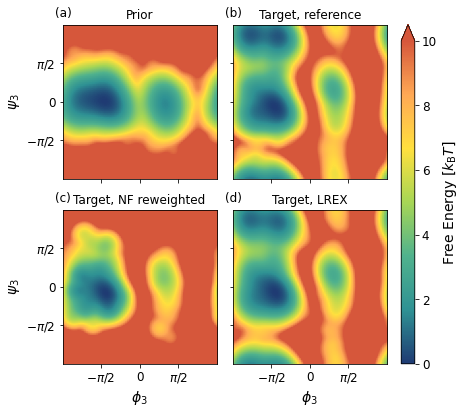

In [145]:
i = 2
vmax = 10

fig = plt.figure(figsize=(6.4, 1.3*4.8))
gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.2)
axs = gs.subplots(sharex=True, sharey=True)
tag_pos = (-0.05, 1.05)

ax = axs[0,0]
ax.text(*tag_pos, '(a)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Prior')
plot_2D_fes(ax, prior_fes[i], vmax=vmax)
ax.set_ylabel(f'$\psi_{1+i}$')
# ax.set_xlabel(None)

ax = axs[0,1]
ax.text(*tag_pos, '(b)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, reference')
plot_2D_fes(ax, opes_fes[i], vmax=vmax)
# ax.set_ylabel(None)

ax = axs[1,0]
ax.text(*tag_pos, '(c)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, NF reweighted')
plot_2D_fes(ax, mapped_fes[i], vmax=vmax)
ax.set_xlabel(f'$\phi_{1+i}$')
ax.set_ylabel(f'$\psi_{1+i}$')

ax = axs[1,1]
ax.text(*tag_pos, '(d)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, LREX')
cb = plot_2D_fes(ax, target_fes[i], vmax=vmax)
ax.set_xlabel(f'$\phi_{1+i}$')
plt.colorbar(cb, ax=axs, label='Free Energy [$k_\mathrm{B}T$]', extend='max', pad=0.04, fraction=0.05, aspect=25)

plt.savefig(f'Ala4-all.pdf', bbox_inches='tight')
plt.show()

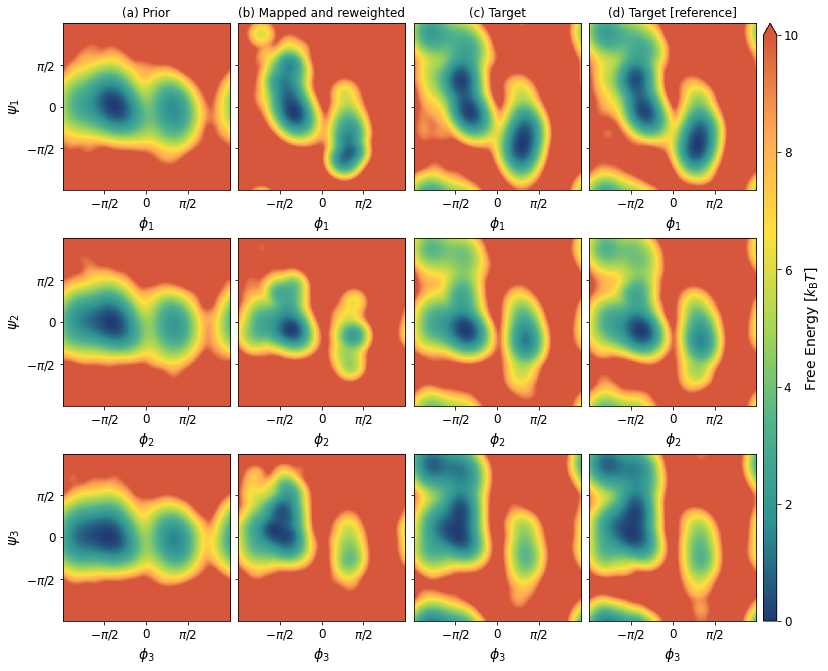

In [35]:
#plot all ramachandran for supporting information
vmax = 10
fig = plt.figure(figsize=(6.4*2, 4.8*2.4))
gs = fig.add_gridspec(3, 4, wspace=0.05, hspace=0.1)
axs = gs.subplots(sharex=False, sharey=False)
axs[0,0].set_title('(a) Prior')
axs[0,1].set_title('(b) Mapped and reweighted')
axs[0,2].set_title('(c) Target')
axs[0,3].set_title('(d) Target [reference]')
for i in range(3):
    plot_2D_fes(axs[i,0], prior_fes[i], vmax)
    plot_2D_fes(axs[i,1], mapped_fes[i], vmax)
    plot_2D_fes(axs[i,2], target_fes[i], vmax)
    cb = plot_2D_fes(axs[i,3], opes_fes[i], vmax)
    for j in range(4):
        axs[i,j].set_xlabel(f'$\phi_{1+i}$')
    axs[i,0].set_ylabel(f'$\psi_{1+i}$')
    axs[i,1].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,2].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,3].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
plt.colorbar(cb, ax=axs, label='Free Energy [$k_\mathrm{B}T$]', extend='max', extendfrac=0.02, pad=0.01, fraction=0.0186, aspect=45)
plt.savefig(f'Ala4-FES_phipsi.pdf', bbox_inches='tight')
plt.show()

## Energies

In [42]:
%%time
import torch
ctx = {"device": torch.device('cpu'), "dtype": torch.float32}

#all energies in the target hamiltonian and in kJ/mol
target_model = get_model(system_name=system_name+target_details, temperature=1/kB)
print('prior ener')
data = np.load(f'{filename}-traj.npz')['T_high']
with torch.no_grad():
    prior_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy()
print('target ener')
data = np.load(f'{filename}-traj.npz')['T_low']
with torch.no_grad():
    target_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy()
print('mapped ener')
data = np.load(f'{filename}-trajMapped.npz')['data']
with torch.no_grad():
    mapped_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy()

Using downloaded and verified file: /tmp/AAA.pdb


/srv/data/minvernizzi/programs/bgflow/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


prior ener
target ener
mapped ener
CPU times: user 24.3 s, sys: 11.8 s, total: 36.1 s
Wall time: 41 s


In [44]:
target_ener.min(), prior_ener.max()

(9.23503, 645.31335)

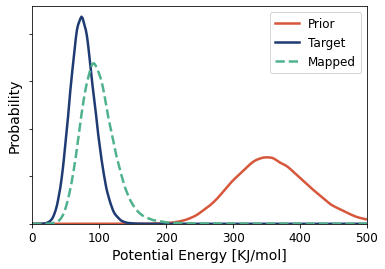

In [49]:
T_high = 1000
T_low = 300
grid = np.linspace(0, 500, 300)

ene = prior_ener
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa6', label='Prior', lw=2.5)
ene = target_ener
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa0', label='Target', lw=2.5)
ene = mapped_ener[mapped_ener<grid[-1]]
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa2', label='Mapped', lw=2.5, ls='--')

plt.xlim(grid[0], grid[-1])
plt.ylim(0, None)
plt.xlabel('Potential Energy [KJ/mol]')
plt.ylabel('Probability')
plt.gca().set_yticklabels([])
plt.legend()
plt.show()